In [ ]:
### Implementing Differential Privacy

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
from scipy.stats import laplace 
import matplotlib.pyplot as plt

First, let's get more familiar with the [Laplace distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.laplace.html).

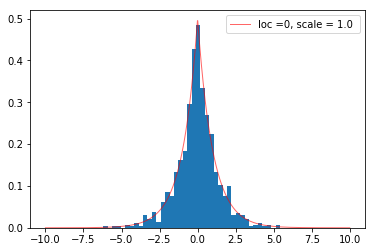

In [30]:
x = np.linspace(-10, 10, 1000 )
y = laplace.pdf(x, 0, 1.0)
plt.plot(x, y,'r-', lw=1, alpha=0.6, label='loc =0, scale = 1.0 ')
plt.legend()



In [19]:
loc, scale = 0, 1.0
#sample from the laplace
s = laplace.rvs(loc, scale, 1000)
laplace.rvs(loc, scale)

-1.0920969364729374

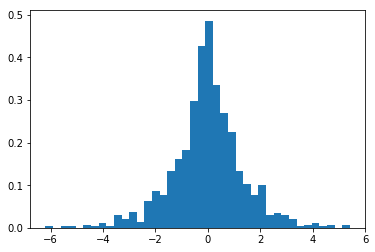

In [31]:
hist= plt.hist(s, 40, normed = True)

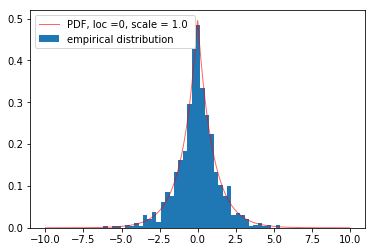

In [35]:
x = np.linspace(-10, 10, 1000 )
y = laplace.pdf(x, loc, scale)
plt.plot(x, y,'r-', lw=1, alpha=0.6, label='PDF, loc =0, scale = 1.0 ')
hist= plt.hist(s, 40, normed = True, label = 'empirical distribution')
plt.legend()

In [37]:
data = pd.read_csv('data/compas-scores-two-years.csv', index_col=0)

In [38]:
#filter it out, like before
df = data[(data['days_b_screening_arrest'] <= 30) & (data['days_b_screening_arrest'] >= -30)]

In [39]:
pd.crosstab(df.v_decile_score, df.sex)

sex,Female,Male
v_decile_score,,
1,410,1266
2,196,727
3,158,675
4,140,545
5,107,480
6,60,448
7,51,325
8,28,226
9,22,209


In [43]:
epsilon = 1.0
sensitivity = 1
def laplace_mech(v, sensitivity, epsilon):
    return v + laplace.rvs(loc=0, scale=sensitivity/epsilon)

In [44]:
pd.crosstab(df.v_decile_score, df.sex).applymap(lambda x: laplace_mech(x, 1, epsilon))

sex,Female,Male
v_decile_score,,
1,409.635833,1266.962019
2,200.315085,726.282775
3,157.718030,674.596662
4,141.982946,546.021688
5,105.133308,480.852961
6,60.956176,447.653069
7,49.083934,325.022789
8,28.050360,225.849712
9,21.683359,208.744384
